In [1]:
from sympy import simplify, parse_expr
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from flash_ansr import SkeletonPool, get_path, ExpressionSpace
from flash_ansr.expressions.utils import num_to_constants, numbers_to_num
from flash_ansr.eval.utils import bootstrapped_metric_ci
import time
import pickle

In [2]:
original_space = ExpressionSpace.from_config(get_path('configs', 'v7.0', 'expression_space.yaml'))

In [3]:
pool = SkeletonPool.from_config(get_path('configs', 'v7.20', 'skeleton_pool_val.yaml'))
pool.sample_strategy['max_operators'] = 15
pool.sample_strategy['max_length'] = 2 * 15 + 1
pool.sample_strategy['max_tries'] = 100
pool.simplify = False

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 30913.91it/s]


In [4]:
len(pool.expression_space.simplification_rules)

705

In [ ]:
for rule in pool.expression_space.simplification_rules:
    # if len(rule[0]) == 5 and '<num>' in rule[0] and '_0' in rule[0] and not any('float' in t for t in rule[0]):
    #     # print(rule)
    #     if rule[0] ==  ('+', '+', '<num>', '_0', '<num>'):
    #         print(rule)
    if len(rule[0]) == 5 and "<num>" in rule[0] and "-" in rule[0]:
        print(rule)

(('+', '1', '-', '<num>', '_0'), ('-', '<num>', '_0'))
(('+', '1', '-', '_0', '<num>'), ('+', '<num>', '_0'))
(('+', '_0', '-', '<num>', '_0'), ('<num>',))
(('+', '<num>', '-', '(-1)', '_0'), ('-', '<num>', '_0'))
(('+', '<num>', '-', '_0', '1'), ('+', '<num>', '_0'))
(('+', '<num>', '-', '_0', '(-1)'), ('+', '<num>', '_0'))
(('+', '<num>', '-', '1', '_0'), ('-', '<num>', '_0'))
(('+', '(-1)', '-', '<num>', '_0'), ('-', '<num>', '_0'))
(('+', '(-1)', '-', '_0', '<num>'), ('+', '<num>', '_0'))
(('+', '-', '<num>', '_0', '1'), ('-', '<num>', '_0'))
(('+', '-', '<num>', '_0', '_0'), ('<num>',))
(('+', '-', '<num>', '_0', '(-1)'), ('-', '<num>', '_0'))
(('+', '-', '(-1)', '_0', '<num>'), ('-', '<num>', '_0'))
(('+', '-', '_0', '1', '<num>'), ('+', '<num>', '_0'))
(('+', '-', '_0', '(-1)', '<num>'), ('+', '<num>', '_0'))
(('+', '-', '_0', '<num>', '1'), ('+', '<num>', '_0'))
(('+', '-', '_0', '<num>', '(-1)'), ('+', '<num>', '_0'))
(('+', '-', '1', '_0', '<num>'), ('-', '<num>', '_0'))
(('-

In [6]:
pool.expression_space.prefix_to_tree(list(('+', '+', '<num>', '_0', '<num>')))

['+', [['+', [['<num>'], ['_0']]], ['<num>']]]

In [7]:
print(pool.expression_space.simplify(('+', '+', '<num>', 'x2', '<num>')))

('+', '<num>', 'x2')


In [8]:
pool.expression_space.match_pattern(['+', [['+', [['<num>'], ['x2']]], ['<num>']]], ['+', [['+', [['<num>'], ['_0']]], ['<num>']]])

(True, {'_0': ['x2']})

In [9]:
# TODO:
# - [x] Make+ rules unique
# - [ ] Find out why rules are sometimes not applied although they are in the rules list. Something with the tree patterns?
# - [ ] rules_trees_from_rules_list is buggy somehow. look at the mismatch above this cell

In [10]:
# Show 5 random rules
import random

for i in range(5):
    rule = random.choice(pool.expression_space.simplification_rules)
    rule_str_0 = str(rule[0])
    rule_str_1 = str(rule[1])
    print(f'{i}: {rule_str_0:<50} -> {rule_str_1}')

0: ('inv', '*', '<num>', '_0')                        -> ('/', '<num>', '_0')
1: ('asin', '(-1)')                                   -> ('<num>',)
2: ('*', 'float("nan")', '_0')                        -> ('float("nan")',)
3: ('pow5', '1')                                      -> ('1',)
4: ('+', '-', '_0', '<num>', '(-1)')                  -> ('+', '<num>', '_0')


In [11]:
expression = ('+', 'x1', '*', 'x3', '/', 'acos', 'x3', 'x3')
new_expression = pool.expression_space.simplify(expression)
print(new_expression)
# FIXME

('+', 'x1', 'acos', 'x3')


In [12]:
expression = (
    '+',
        '*',
            '+', 'x3', 'x2',
            '-', 'x3', 'x3',
    'x3')
expression_tree, annotated_expression_tree, stack_labels = pool.expression_space.collect_multiplicities(expression)
# print(expression_tree)
# print(annotated_expression_tree)
# print(stack_labels)
new_expression = pool.expression_space.cancel_terms(expression_tree, annotated_expression_tree, stack_labels)
new_expression

['+', '*', '+', 'x3', 'x2', '-', '0', '0', 'x3']

In [13]:
expression = ('+', '+', '<num>', '*', '<num>', 'x1', '<num>')            
expression_tree, annotated_expression_tree, stack_labels = pool.expression_space.collect_multiplicities(expression)
# print(expression_tree)
# print(annotated_expression_tree)
# print(stack_labels)
new_expression = pool.expression_space.cancel_terms(expression_tree, annotated_expression_tree, stack_labels)
new_expression

['+', '+', '<num>', '*', '<num>', 'x1', '0']

In [14]:
expression = ('+', '+', 'x1', '*', 'x1', 'x2', 'x1')            
expression_tree, annotated_expression_tree, stack_labels = pool.expression_space.collect_multiplicities(expression)
# print(expression_tree)
# print(annotated_expression_tree)
# print(stack_labels)
new_expression = pool.expression_space.cancel_terms(expression_tree, annotated_expression_tree, stack_labels)
new_expression

['+', '+', 'mult_2', 'x1', '*', 'x1', 'x2', '0']

In [15]:
expression = ('+', '+', '<num>', '*', '<num>', 'x1', '<num>')
assert pool.expression_space.is_valid(expression)
new_expression = pool.expression_space.simplify(expression)
print(new_expression)

('+', '<num>', '*', '<num>', 'x1')


In [16]:
expression = ('div5', '/', 'x1', '*', 'pow3', 'x1', '<num>')
assert pool.expression_space.is_valid(expression)
new_expression = pool.expression_space.simplify(expression, max_iter=5, mask_elementary_literals=True)
print(new_expression)

('div5', '/', 'x1', '*', '<num>', 'pow3', 'x1')


In [17]:
expression = ['+', '-', 'sin', 'sin', '-', 'x2', 'x2', 'log', 'x1', 'x3']
assert pool.expression_space.is_valid(expression)
new_expression = pool.expression_space.simplify(expression, max_iter=5, mask_elementary_literals=True)
print(new_expression)
assert new_expression == ['-', 'x3', 'log', 'x1']

['-', 'x3', 'log', 'x1']


In [18]:
expression = pool.expression_space.simplify(('+', 'tan', 'x1', '-', 'log', '<num>', 'inv', 'x2'))
print(expression)
assert expression == ('+', 'tan', 'x1', '-', '<num>', 'inv', 'x2')

('+', 'tan', 'x1', '-', '<num>', 'inv', 'x2')


In [19]:
expression = pool.expression_space.simplify(('abs', '*', '-', 'x3', 'x2', 'sin', '-', '<num>', '<num>'))
print(expression)
assert expression == ('abs', '*', '<num>', '-', 'x3', 'x2')

('abs', '*', '<num>', '-', 'x3', 'x2')


In [20]:
expression = pool.expression_space.sort_operands(('abs', '*', 'sin', '-', '<num>', '<num>', '-', '<num>', 'x2', ))
print(expression)

['abs', '*', '-', '<num>', 'x2', 'sin', '-', '<num>', '<num>']


In [21]:
expression = pool.expression_space.simplify(('+', '<num>', '+', 'x2', '<num>',))
print(expression)
assert expression == ('+', '<num>', 'x2')

('+', '<num>', 'x2')


In [22]:
expression = pool.expression_space.simplify(('+', '+', '<num>', '<num>', '<num>'))
print(expression)
assert expression == ('<num>',)

('<num>',)


In [23]:
expression = pool.expression_space.simplify(('atan', 'tan', 'x2'))
print(expression)
assert expression == ('atan', 'tan', 'x2')

('atan', 'tan', 'x2')


In [24]:
expression = pool.expression_space.simplify(('-', '<num>', '+', '<num>', 'x1'))
print(expression)
assert expression == ('-', '<num>', 'x1')

('-', '<num>', 'x1')


In [25]:
expression = pool.expression_space.simplify(('-', '<num>', '+', '<num>', '+', '+', 'x1', 'x2', '<num>'))
print(expression)
assert expression == ('-', '<num>', '+', 'x1', 'x2')

('-', '<num>', '+', 'x1', 'x2')


In [26]:
x = np.random.normal(0, 5, 1024)
np.allclose(np.atan(np.tan(x)), x)

False

In [27]:
N_SAMPLES = 10_000

In [28]:
simplified_skeletons = {}
simplification_times = {}

pbar = tqdm(total=N_SAMPLES, smoothing=0)
while len(simplified_skeletons) < N_SAMPLES:
    skeleton, _, _ = pool.sample_skeleton()

    if skeleton in simplified_skeletons:
        continue
    # pbar.set_postfix_str(f'{len(skeleton)}: {skeleton}')

    try:
        original_time_1 = time.time()
        original_simplified = original_space.simplify(skeleton, max_iter=5)
        original_time_2 = time.time()

        auto_time1 = time.time()
        auto_simplified = pool.expression_space.simplify(skeleton, max_iter=5)
        auto_time2 = time.time()

        simplified_skeletons[skeleton] = {
            'original': original_simplified,
            'auto': auto_simplified,
        }
        simplification_times[skeleton] = {
            'original': original_time_2 - original_time_1,
            'auto': auto_time2 - auto_time1,
        }

    except (IndexError, ValueError):
        continue

    pbar.update(1)

pbar.close()

100%|██████████| 10000/10000 [00:19<00:00, 520.31it/s]


In [29]:
max_i = 10
i = 0
for original, simplified in simplified_skeletons.items():
    if len(simplified['auto']) == 1:
        print(original)
        print(simplified['auto'])
        print(simplified['original'])
        print()
        i += 1
        if i >= max_i:
            break

('+', '*', 'pow2', '-', 'x3', 'x3', 'inv', '+', '<num>', '-', 'pow1_2', 'x3', '+', '<num>', '/', 'x2', 'pow1_2', '<num>', 'x2')
('x2',)
['+', 'x2', 'inv', '-', 'pow1_2', 'x3', '+', '<num>', '/', 'x2', '<num>']

('pow1_2', '-', '-', '<num>', '+', '<num>', '-', '*', 'x3', '+', '/', '<num>', '-', 'x1', 'x1', '-', 'inv', 'x2', '<num>', '<num>', '*', '<num>', 'x2')
('<num>',)
['pow1_2', 'neg', '+', 'x2', '*', 'x3', '+', '<num>', 'inv', 'x2']

('+', '-', 'x3', '-', '*', 'pow1_5', '+', 'pow2', 'x1', 'x1', 'x3', 'inv', '/', 'x2', '+', 'exp', 'inv', '-', 'x3', 'x3', 'x3', 'neg', '<num>')
('<num>',)
['+', '<num>', '+', 'x3', '-', '/', '+', '<num>', 'x3', 'x2', '*', 'x3', 'pow1_5', '+', 'x1', 'pow2', 'x1']

('pow1_3', 'atan', 'cos', '/', 'x2', 'x2')
('<num>',)
['<num>']

('log', '*', 'pow2', '/', '<num>', '*', 'sin', 'mult2', '<num>', 'pow1_2', '+', '+', 'x1', 'x2', '<num>', '-', 'x2', 'x2')
('<num>',)
['log', '/', 'pow1_2', '+', '<num>', '+', 'x1', 'x2', '<num>', '<num>']

('/', 'neg', '/', 'x2'

In [30]:
max_i = 10
i = 0
for original, simplified in simplified_skeletons.items():
    if len(simplified['auto']) > len(simplified['original']) and random.random() < 0.5:
        print(original)
        print(simplified['auto'])
        print(simplified['original'])
        print()
        i += 1
        if i >= max_i:
            break

('/', '/', '-', 'x1', 'x2', '-', 'x3', '-', 'x1', '+', '*', 'inv', 'x3', 'x1', 'x2', '/', 'neg', '*', '/', '<num>', 'x1', 'x1', 'pow3', 'x2')
('/', '/', '-', 'x1', 'x2', '-', 'x3', '-', 'x1', '+', 'x2', '*', 'x1', 'inv', 'x3', '/', '<num>', 'pow3', 'x2')
['*', '-', 'x1', 'x2', '/', '/', 'pow3', 'x2', '<num>', '+', 'x2', '+', 'x3', '-', '/', 'x1', 'x3', 'x1']

('*', 'x3', '-', '+', 'x3', 'log', '*', 'inv', 'tan', '<num>', 'div3', '-', 'sin', '*', 'x1', 'x2', 'abs', '*', '<num>', '<num>', 'inv', 'abs', 'x2')
('*', 'x3', '-', '+', 'x3', 'log', '*', '<num>', 'div3', '-', 'sin', '*', 'x1', 'x2', '<num>', 'inv', 'abs', 'x2')
['*', 'x3', '+', '<num>', '+', '<num>', '-', 'x3', 'sin', '*', 'x1', 'x2', 'inv', 'abs', 'x2']

('*', 'asin', 'x3', '-', 'acos', '<num>', 'tan', '/', 'x1', '-', '*', 'x2', 'x1', '-', 'mult4', 'tan', '<num>', 'x2')
('*', 'asin', 'x3', '-', '<num>', 'tan', '/', 'x1', '-', '*', 'x1', 'x2', '-', '<num>', 'x2')
['*', 'asin', 'x3', '-', '<num>', 'tan', 'inv', 'x2', 'x2']

('*'

In [31]:
min_length, max_length = np.inf, -np.inf
for k, v in simplified_skeletons.items():
    min_length = np.min([min_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])
    max_length = np.max([max_length, len(k)] + [len(vi) for vi in v.values() if vi is not None])

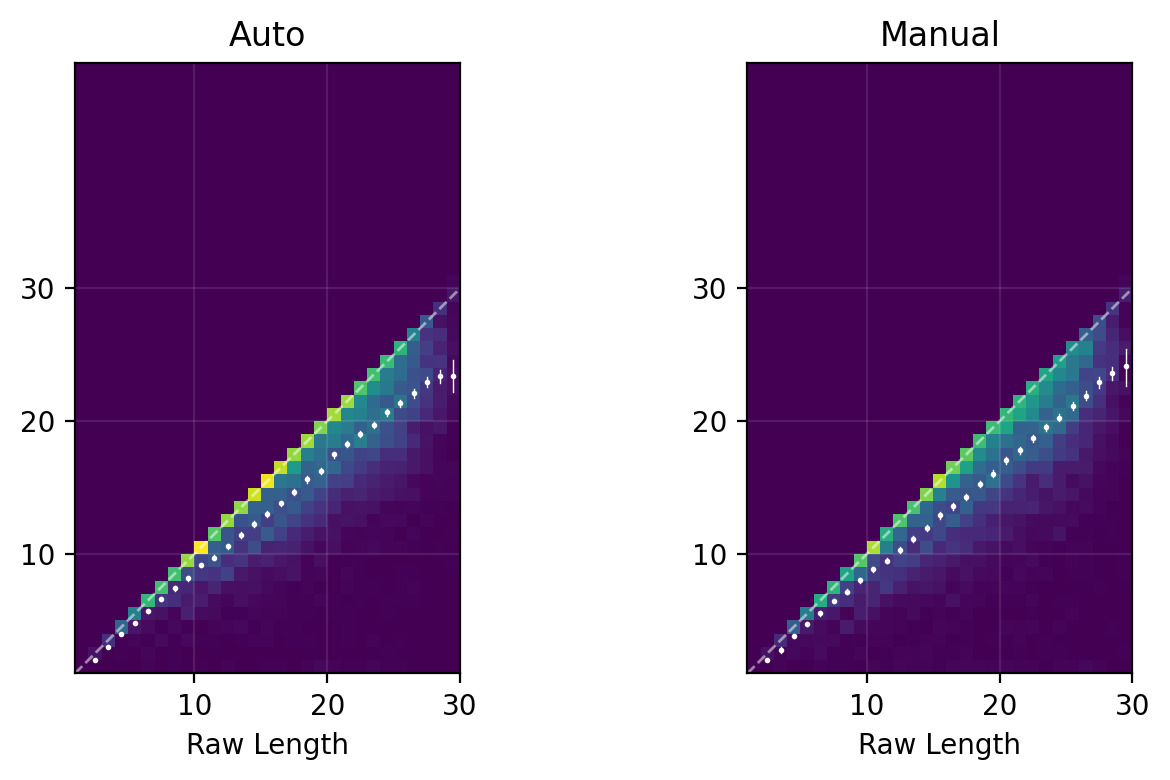

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

axes = np.atleast_1d(axes)

raw_bins = np.arange(min_length, 31)
simplified_bins = np.arange(min_length, 48)

vmin, vmax = np.inf, -np.inf

for method in ['auto', 'original']:
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)
    h = np.histogram2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins]);
    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method, name in zip(axes, ['auto', 'original'], ['Auto', 'Manual']):
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    valid_mask = ~np.isnan(simplified_lengths)

    ax.hist2d(original_lengths[valid_mask], simplified_lengths[valid_mask], bins=[raw_bins, simplified_bins], cmap='viridis', vmin=vmin, vmax=vmax, linewidth=0, rasterized=True);
    ax.set_xlabel('Raw Length')
    if method == 'custom':
        ax.set_ylabel(f'Simplified Length\n$\\leftarrow$')
    ax.set_title(name)
    ax.grid(color='white', alpha=0.1)
    # ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(np.arange(0, max_length + 1, 10))
    ax.set_yticks(np.arange(0, max_length + 1, 10))

    ax.set_facecolor(plt.get_cmap('viridis')(0))

    ax.set_xlim(*raw_bins[[0, -1]])
    ax.set_ylim(*simplified_bins[[0, -1]])

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Draw a line that shows the median simplified length for each raw length
    x_list = []
    y_list = []
    y_upper_list = []
    y_lower_list = []
    for i in range(len(raw_bins) - 1):
        raw_mask = (original_lengths >= raw_bins[i]) & (original_lengths < raw_bins[i + 1])
        if np.any(raw_mask):
            statistic, lower, upper = bootstrapped_metric_ci(simplified_lengths[raw_mask], np.nanmean)
            x_list.append((raw_bins[i] + raw_bins[i + 1]) / 2)
            y_list.append(statistic)
            y_upper_list.append(upper)
            y_lower_list.append(lower)
    ax.scatter(x_list, y_list, color='w', s=1)
    for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
        ax.plot([x, x], [y_lower, y_upper], color='w', lw=0.5)
    # Draw a diagonal
    ax.plot([1, max_length], [1, max_length], color='white', lw=1, ls='--', alpha=0.5)

# # Show the flash.png image next to the ANSR header
# flash = plt.imread(get_path('assets', 'flash.png'))

# # Create a new image with the flash.png image
# # Apparently there is no feasable way to write emojis in matplotlib WTF?!
# ax_image = fig.add_axes([0.195, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')

fig.tight_layout(w_pad=-8)
# plt.savefig(get_path('results', 'simplification', filename='length_custom_vs_sympy_10k_unique.svg', create=True), bbox_inches='tight')

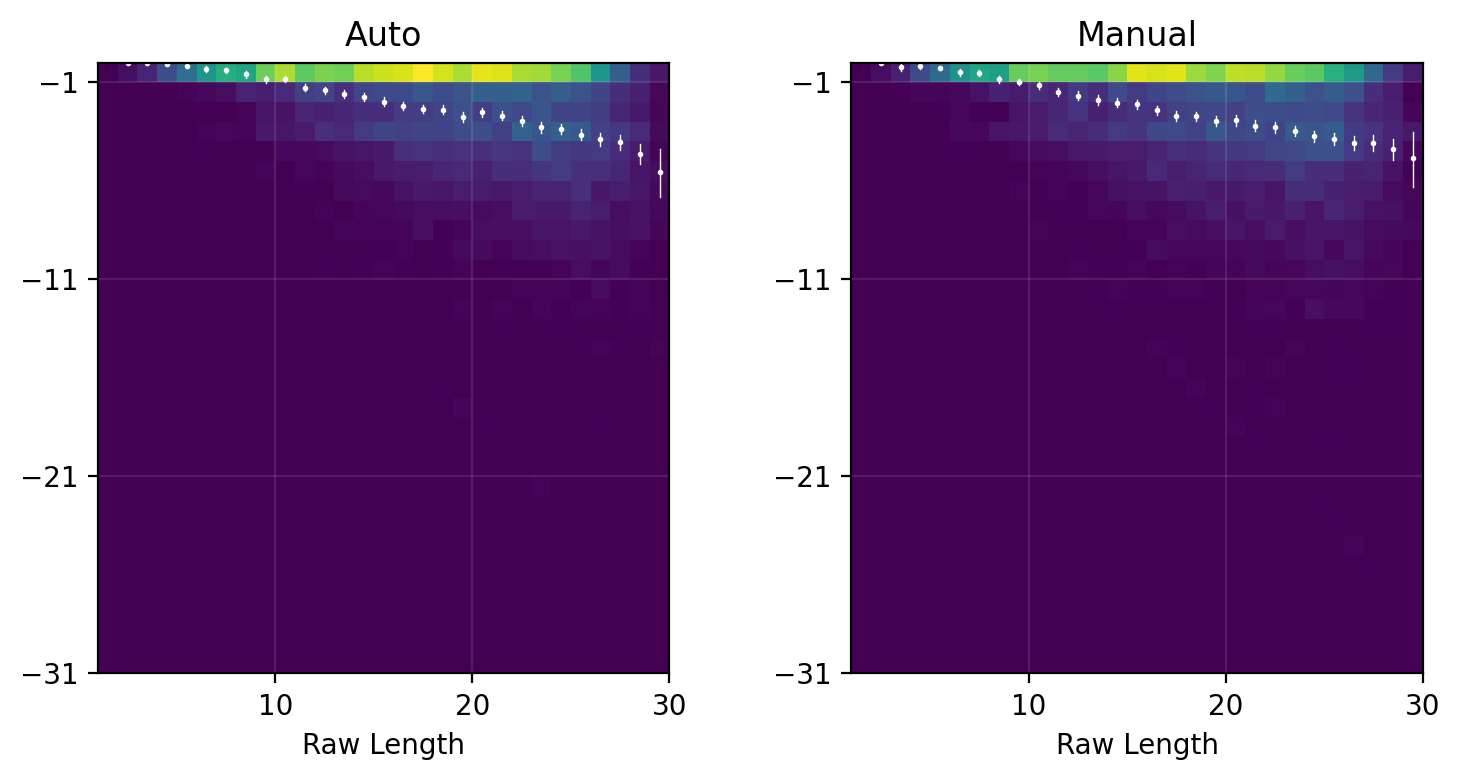

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=200)

axes = np.atleast_1d(axes)

raw_bins = np.arange(min_length, 31)
simplified_bins = np.arange(-31, 1)

vmin, vmax = np.inf, -np.inf

for method in ['auto', 'original']:
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    length_difference = simplified_lengths - original_lengths
    valid_mask = ~np.isnan(length_difference)
    h = np.histogram2d(original_lengths[valid_mask], length_difference[valid_mask], bins=[raw_bins, simplified_bins]);
    vmin = min(vmin, h[0].min())
    vmax = max(vmax, h[0].max())

for ax, method, name in zip(axes, ['auto', 'original'], ['Auto', 'Manual']):
    original_lengths = np.array([len(k) for k in simplified_skeletons.keys()])
    simplified_lengths = np.array([np.nan if v[method] is None else len(v[method]) for v in simplified_skeletons.values()])
    length_difference = simplified_lengths - original_lengths
    valid_mask = ~np.isnan(length_difference)

    ax.hist2d(original_lengths[valid_mask], length_difference[valid_mask], bins=[raw_bins, simplified_bins], cmap='viridis', vmin=vmin, vmax=vmax, linewidth=0, rasterized=True);
    ax.set_xlabel('Raw Length')
    if method == 'custom':
        ax.set_ylabel(f'Simplified Length\n$\\leftarrow$')
    ax.set_title(name)
    ax.grid(color='white', alpha=0.1)
    # ax.set_aspect('equal', adjustable='box')

    ax.set_xticks(np.arange(0, max_length + 1, 10))
    ax.set_yticks(np.arange(-31, 1, 10))

    ax.set_facecolor(plt.get_cmap('viridis')(0))

    ax.set_xlim(*raw_bins[[0, -1]])
    ax.set_ylim(*simplified_bins[[0, -1]])

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Draw a line that shows the median simplified length for each raw length
    x_list = []
    y_list = []
    y_upper_list = []
    y_lower_list = []
    for i in range(len(raw_bins) - 1):
        raw_mask = (original_lengths >= raw_bins[i]) & (original_lengths < raw_bins[i + 1])
        if np.any(raw_mask):
            statistic, lower, upper = bootstrapped_metric_ci(length_difference[raw_mask], np.nanmean)
            x_list.append((raw_bins[i] + raw_bins[i + 1]) / 2)
            y_list.append(statistic)
            y_upper_list.append(upper)
            y_lower_list.append(lower)
    ax.scatter(x_list, y_list, color='w', s=1)
    for x, y, y_upper, y_lower in zip(x_list, y_list, y_upper_list, y_lower_list):
        ax.plot([x, x], [y_lower, y_upper], color='w', lw=0.5)
    # Draw a diagonal
    ax.plot([1, max_length], [1, max_length], color='white', lw=1, ls='--', alpha=0.5)

# # Show the flash.png image next to the ANSR header
# flash = plt.imread(get_path('assets', 'flash.png'))

# # Create a new image with the flash.png image
# # Apparently there is no feasable way to write emojis in matplotlib WTF?!
# ax_image = fig.add_axes([0.195, 0.925, 0.04, 0.04], anchor='NE', zorder=10)
# ax_image.imshow(flash)
# ax_image.axis('off')

fig.tight_layout(w_pad=-8)
# plt.savefig(get_path('results', 'simplification', filename='length_custom_vs_sympy_10k_unique.svg', create=True), bbox_inches='tight')

Text(0.5, 1.0, 'Auto')

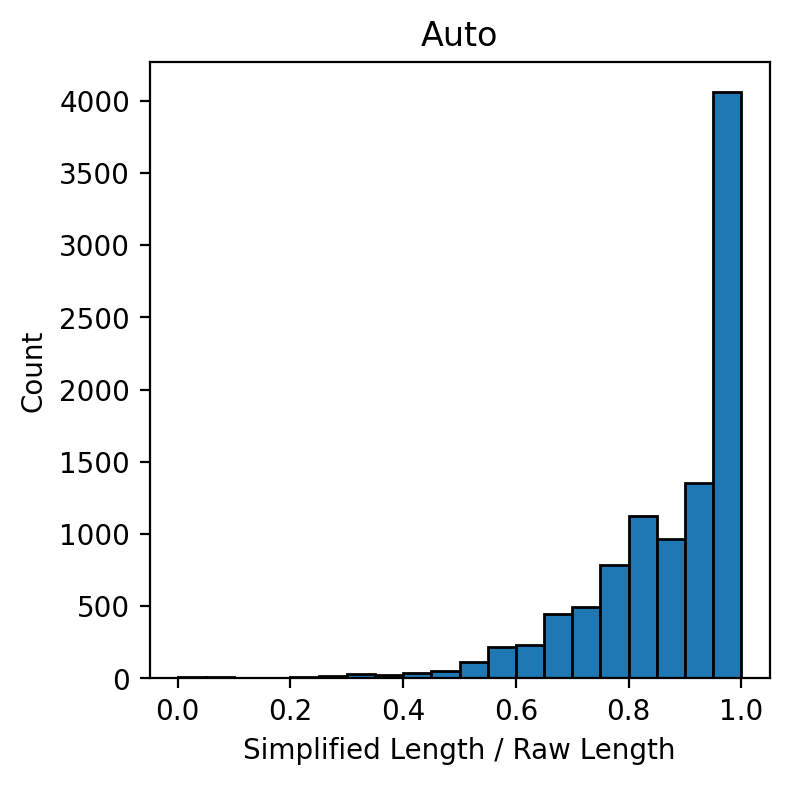

In [34]:
# Show the ratios of the simplified lengths
ratios = []
for k, v in simplified_skeletons.items():
    if v['auto'] is not None:
        ratios.append(len(v['auto']) / len(k))
ratios = np.array(ratios)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.hist(ratios, bins=np.linspace(0, 1, 21), color='C0', edgecolor='black')
ax.set_xlabel('Simplified Length / Raw Length')
ax.set_ylabel('Count')
ax.set_title('Auto')

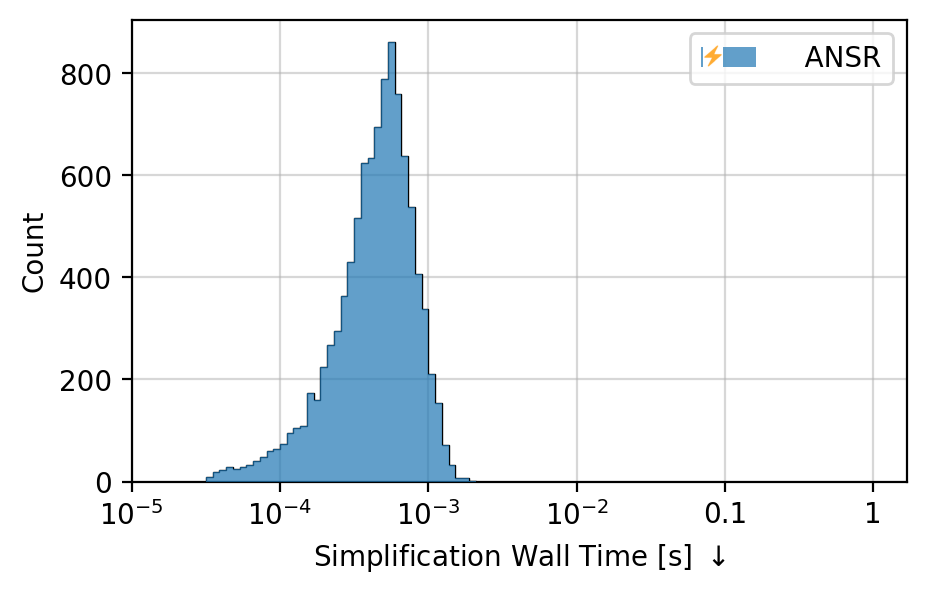

In [35]:
# Show simplification times
auto_times = np.array([v['auto'] for v in simplification_times.values()])

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

bins=np.linspace(-4.5, 0, 100)

ax.hist(np.log10(auto_times), bins=bins, alpha=0.7, label='   ANSR', color='tab:blue', zorder=3, linewidth=0, rasterized=True);

# Same thing but only outline
ax.hist(np.log10(auto_times), bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)


# Show the flash.png image next to the ANSR header
flash = plt.imread(get_path('assets', 'flash.png'))

# Create a new image with the flash.png image
# Apparently there is no feasable way to write emojis in matplotlib WTF?!
ax_image = fig.add_axes([0.675, 0.80, 0.04, 0.04], anchor='NE', zorder=10)
ax_image.imshow(flash)
ax_image.axis('off')


ax.set_xticks(np.arange(-5, 1))
labels = [f'$10^{{{i}}}$' for i in np.arange(-5, 1)]
labels[-2] = '0.1'
labels[-1] = '1'
ax.set_xticklabels(labels)

ax.set_xlabel('Simplification Wall Time [s] $ \\downarrow $')
ax.set_ylabel('Count')
ax.legend();
ax.grid(alpha=0.5, zorder=0)
# plt.savefig(get_path('results', 'simplification', filename='simplification_times_auto_vs_sympy_10k_unique.svg', create=True), bbox_inches='tight')